In [1]:
import sys, os, time

import numpy as np
import matplotlib.pyplot as plt

import adi
from pysmu import Session, Mode

In [2]:
# Pluto SDR parameters
sample_rate = int(1e6) # Hz
tone_freq = int(1e3) # Hz
center_freq = int(2.45e9) - tone_freq # Hz
n_samples = 2**12 # number of samples returned per call to rx()/tx()

sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = sample_rate
sdr.tx_rf_bandwidth = sample_rate # filter cutoff, just set it to the same as sample rate
sdr.tx_lo = center_freq

sdr.gain_control_mode_chan0 = 'manual'
sdr.tx_hardwaregain_chan0 = -50 # Increase to increase tx power, valid range is -89 to 0 dB

sdr.tx_cyclic_buffer = True

In [3]:
# ADALM1000 ADC parameters 
session = Session()

if not session.devices:
    # no devices found
    print("No devices found!")
    sys.exit(1)
    
dev = session.devices[0]

# single device operation
chan_a = dev.channels['A']
chan_b = dev.channels['B']
# CH A voltage source, AIN voltage reader
chan_a.mode = Mode.SVMI_SPLIT
# CH B voltage source, BIN voltage reader
chan_b.mode = Mode.SVMI_SPLIT

session.start(0)
num_samples = session.queue_size + 1

# DC bias
chan_a.write([0.0] * num_samples, -1)
# unused
chan_b.write([0.0] * num_samples, -1)

In [4]:
# flush the old samples from read buffer
dev.read(0, timeout=0, skipsamples=True)
# get the fresh samples
samples = dev.read(10, timeout=-1)

samp_chan_a, samp_chan_b = zip(*samples)
v_chan_a, i_chan_a = zip(*samp_chan_a)
v_chan_b, i_chan_b = zip(*samp_chan_b)

print("V chan A:", np.average(v_chan_a)) # V magnitude
print("V chan B:", np.average(v_chan_b)) # V phase

V chan A: 1.0488366484642029
V chan B: 1.0484878897666932


In [5]:
t_lin = np.linspace(0, 1, num=n_samples)
tx_samples = np.exp(2j*np.pi*t_lin*tone_freq)
tx_samples *= 2**14 # The PlutoSDR expects samples to be between -2^14 and +2^

n_points = 100
avg_len = 1e4
v_bias_lst = np.linspace(0.0, 5.0, n_points, endpoint=True)

freq_lst = [2400e6, 2450e6, 2500e6]
ad8302_vphase_per_freq_lst = []
ad8302_vmag_per_freq_lst = []
for center_freq in freq_lst:
    sdr.tx_lo = int(center_freq - tone_freq)
    sdr.tx_hardwaregain_chan0 = 0
    sdr.tx(tx_samples)

    ad8302_vphase = np.zeros(n_points)
    ad8302_vmag = np.zeros(n_points)
    
    for v_bias_idx, v_bias in enumerate(v_bias_lst):
        # write bias voltage
        chan_a.write([v_bias] * num_samples, -1)
                
        # flush the old samples from read buffer
        dev.read(0, timeout=0, skipsamples=True)
        # get the fresh samples
        samples = dev.read(avg_len, timeout=-1)
        samp_chan_a, samp_chan_b = zip(*samples)
        v_chan_a, i_chan_a = zip(*samp_chan_a)
        v_chan_b, i_chan_b = zip(*samp_chan_b)
        ad8302_vmag[v_bias_idx] = np.average(v_chan_a)
        ad8302_vphase[v_bias_idx] = np.average(v_chan_b)
    
    ad8302_vphase_per_freq_lst.append(ad8302_vphase)
    ad8302_vmag_per_freq_lst.append(ad8302_vmag)
    sdr.tx_destroy_buffer()
print("Finished measurement!")

Finished measurement!


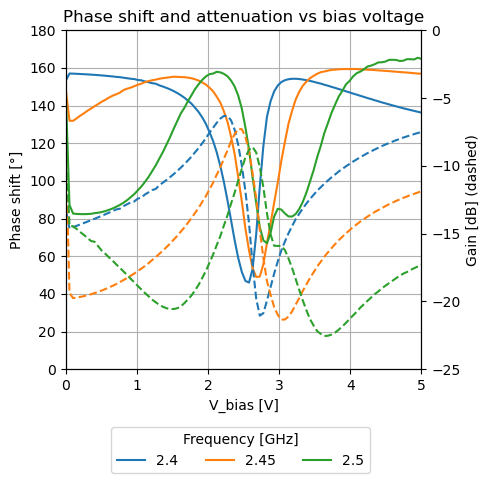

In [6]:
fig, ax1 = plt.subplots(1,1, figsize=(5, 5))
ax2 = ax1.twinx()

v_mag_diff_min = -30
v_mag_slope = 0.030 # 30mV/dB
v_mag_mid = 0.9

v_phase_peak = 1.8
v_phase_slope = 0.010 # +/-10mV/deg
# the measured v_phase does not cross 1.8V - the measured phase difference is limited to [-180;0] or [0;180] range 
# maybe the phase characteristic peak is at 1.6V then this phase shifter achieves 180 deg range at most
for tone_idx, tone_freq in enumerate(freq_lst):
    pha_shift = ad8302_vphase_per_freq_lst[tone_idx] / v_phase_slope
    att_db = (ad8302_vmag_per_freq_lst[tone_idx] - v_mag_mid) / v_mag_slope
    ax1.plot(v_bias_lst, pha_shift, label=tone_freq / 1e9, linestyle="-")
    ax2.plot(v_bias_lst, att_db, label=tone_freq / 1e9, linestyle="--")

ax1.set_xlim([0.0, 5.0])
ax1.set_ylim([0, 180])
ax1.set_ylabel("Phase shift [°]")
ax1.set_xlabel("V_bias [V]")
ax1.set_title("Phase shift and attenuation vs bias voltage")
ax1.grid()
ax1.legend(title="Frequency [GHz]", ncol=3, bbox_to_anchor=(0.875, -0.15))

ax2.set_xlim([0.0, 5.0])
ax2.set_ylim([-25.0, 0.0])
ax2.set_ylabel("Gain [dB] (dashed)")

plt.tight_layout()
plt.savefig("results/analog_rf_phase_shifter_distributed_2_45_GHz_tested_%sMHz.png" %('_'.join([str(int(val / 1e6)) for val in freq_lst])), dpi=600, bbox_inches='tight')
plt.show()

# Testbed setup
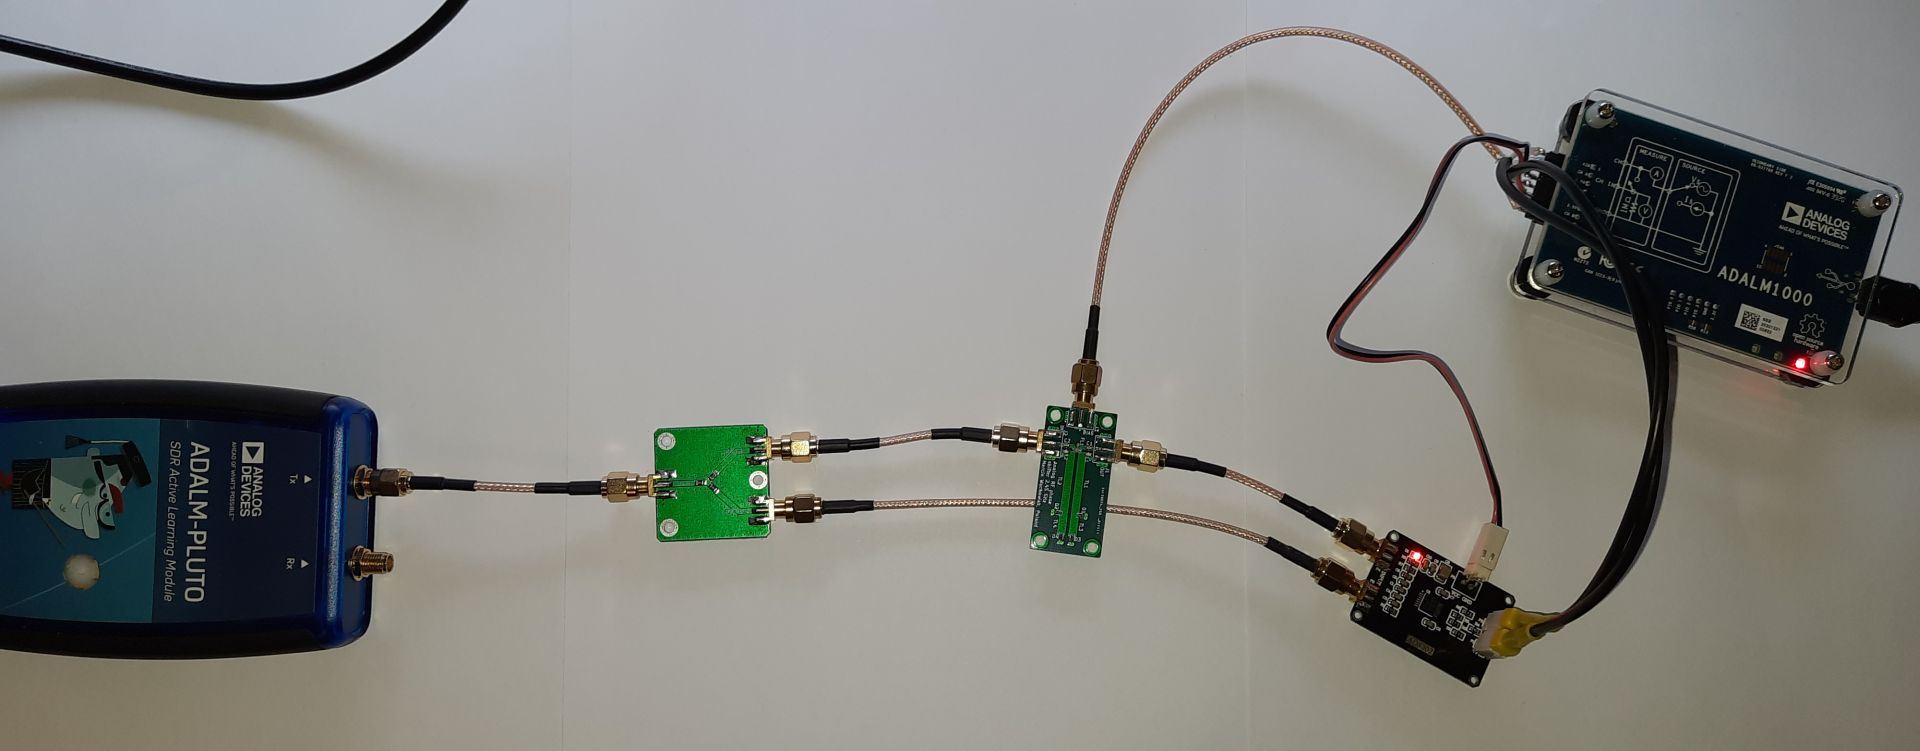